


# Tony's Random Forest Model
## resampling to match state distribution might help with public leaderboard score

In [1]:
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import seaborn as sn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


def convert_to_min(old_time):
  '''
  Convert the input time in 4-digit military form to an integer representing 
  the amount of corresponding minutes.
  
  Inputs:
    - old_time - 4 digit number representing military time ex: 1350 for 1:50 pm

  Output:
    - new_time - the input time as an integer in minutes
  '''
  if np.isnan(old_time):
    new_time = np.nan
  else:
      time_str = str(int(float(old_time)))
      if len(time_str) == 4:
        hr = int(time_str[:2])
        min = int(time_str[2:])
      elif len(time_str) == 3:
        hr = int(time_str[:1])
        min = int(time_str[1:])
      else:
        hr = 0
        min = int(time_str)

      new_time = 60 * hr + min
  return new_time

# Seed the random number generator:
np.random.seed(1)

def prep_data(df, with_label = True):
  df_trim = df

  # apply the conversion function to the whole discovery time column
  df_trim['DISCOVERY_TIME'] = df_trim['DISCOVERY_TIME'].map(convert_to_min)

  # imputation: fill NaN values with the average discovery time
  discovery_time_mean = df_trim['DISCOVERY_TIME'].mean()
  df_trim['DISCOVERY_TIME'] = df_trim['DISCOVERY_TIME'].fillna(discovery_time_mean)

  # One Hot Coding for States
  States = pd.get_dummies(df_trim.STATE, prefix='STATE')
  df_trim = df_trim.join(States)

  CA_num = df_trim['STATE_CA'].sum()
  GA_num = df_trim['STATE_GA'].sum()

  df_trim['DATE'] = pd.to_datetime(df_trim['DATE'])
  df_trim['DAY'] = df_trim['DATE'].dt.day
  df_trim['DAYOFYEAR'] = df_trim['DATE'].dt.dayofyear
  df_trim['MONTH'] = df_trim['DATE'].dt.month
  df_trim['YEAR'] = df_trim['DATE'].dt.year

  # Choose what final features (columns) to include in the training process, and their order.
  final_features = ['LONGITUDE','LATITUDE','YEAR','DAYOFYEAR','DISCOVERY_TIME','FIRE_SIZE']

  if with_label:
    df_trim =  df_trim[final_features + ['LABEL']]
  else:
    df_trim =  df_trim[final_features]

  data = df_trim.to_numpy()
  print(df_trim.head(5))
  print("State Ratio CA/GA ", CA_num / GA_num)
  return data



## Data Loading

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/AntonioLiu97/Kaggle-Competition/main/WILDFIRES_TRAIN.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/AntonioLiu97/Kaggle-Competition/main/WILDFIRES_TEST.csv')

In [3]:
df_train.head(5)

,id,LATITUDE,LONGITUDE,STATE,DISCOVERY_TIME,FIRE_SIZE,FIPS_NAME,FIPS_CODE,SOURCE_REPORTING_UNIT_NAME,DATE,LABEL
0,0,38.205000,-120.335000,CA,130.0,0.10,NaN,NaN,Stanislaus National Forest,1992-01-01,1
1,1,33.813100,-85.104300,GA,1115.0,1.17,Haralson,143.0,Georgia Forestry Commission,1992-01-01,4
2,2,32.201000,-82.498700,GA,1600.0,0.07,Montgomery,209.0,Georgia Forestry Commission,1992-01-01,2
3,3,32.509300,-81.708600,GA,1215.0,4.40,Bulloch,31.0,Georgia Forestry Commission,1992-01-01,4
4,4,33.663889,-116.171944,CA,NaN,0.20,NaN,NaN,CDF - Riverside Unit,1992-01-01,2


In [4]:
# drop 44560 data points from Georgia, so that the state distribution matches that of the test data
id_GA = df_train.index[df_train['STATE'] == 'GA'].tolist()
np.random.shuffle(id_GA)
id_drop = id_GA[0:44560]

df_train_resampled = df_train.drop(id_drop)

data_train = prep_data(df_train_resampled, with_label = True)
data_test = prep_data(df_test, with_label = False)


    LONGITUDE   LATITUDE  YEAR  DAYOFYEAR  DISCOVERY_TIME  FIRE_SIZE  LABEL
0 -120.335000  38.205000  1992          1       90.000000       0.10      1
1  -85.104300  33.813100  1992          1      675.000000       1.17      4
3  -81.708600  32.509300  1992          1      735.000000       4.40      4
4 -116.171944  33.663889  1992          1      855.545049       0.20      2
5 -116.634200  33.166700  1992          1      810.000000       5.00      2
State Ratio CA/GA  1.5243396226415094
    LONGITUDE   LATITUDE  YEAR  DAYOFYEAR  DISCOVERY_TIME  FIRE_SIZE
0 -117.442222  34.346944  2010          1      965.000000        0.2
1 -116.179970  34.020390  2010          1      945.000000        0.1
2 -120.276667  38.068611  2010          1      720.000000        0.1
3  -83.742573  32.499971  2010          2      866.664124        0.4
4 -114.992530  32.924940  2010          2       86.000000        0.1
State Ratio CA/GA  1.5265506624692982


In [5]:
X_train = data_train[:,0:-1]
Y_train = data_train[:,-1]

X_test = data_test

# split training and validating data
# train on 99% of all training data, and validate on 1%
X_train, X_validate, Y_train, Y_validate = train_test_split(X_train, Y_train, test_size = 0.01)

# normalize all data w.r.t training data:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

print(X_train)
print(Y_train[0:5])

print(len(X_train),len(X_validate))




[[ 1.22657329e+00 -1.48761723e+00 -1.59546825e+00  9.78735484e-01
  -2.77737587e-01 -2.82600772e-02]
 [-8.02108402e-01  4.44388063e-01 -6.24488434e-01 -4.50188427e-01
  -5.44375782e-05 -2.63854698e-02]
 [ 1.34196142e+00 -1.26817488e+00 -4.19005446e-02 -8.45175524e-01
   5.73797606e-01 -2.83119694e-02]
 ...
 [ 1.32703796e+00 -7.85970566e-01 -6.24488434e-01 -1.54221158e+00
   7.38610869e-01 -1.61821568e-02]
 [ 1.17051339e+00 -2.60665410e-01 -6.24488434e-01 -8.68410059e-01
  -2.50268710e-01 -2.80719678e-02]
 [ 1.30883518e+00 -1.47227881e+00  1.31747120e+00  1.82679602e+00
  -5.44375782e-05 -2.80071025e-02]]
[2. 4. 2. 3. 3.]
238413 2409


# Modeling: Find Optimal Hyper-parameter for Random Forest (Multi-Class)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

np.random.seed(2)

estimator_num = 40
clf = RandomForestClassifier(n_estimators = estimator_num, criterion = 'gini')

max_depth = np.arange(10, 50, 5)


AUC_scores_train_2 = []
AUC_scores_validate_2 = []

for d in max_depth:
  clf.max_depth = d
  clf.fit(X_train, Y_train)

  AUC_scores_validate_2 += [roc_auc_score(Y_validate, clf.predict_proba(X_validate), multi_class='ovr')]
  AUC_scores_train_2 += [roc_auc_score(Y_train, clf.predict_proba(X_train), multi_class='ovr')]




## Learning Curves

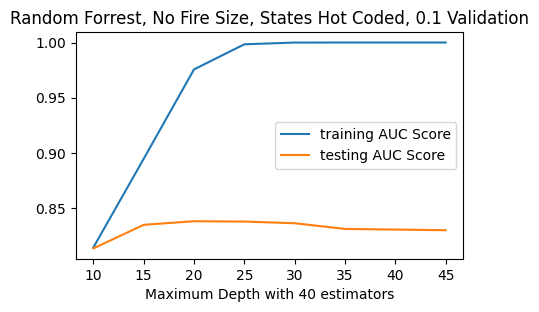

In [13]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(max_depth[0:10], AUC_scores_train_2)
plt.plot(max_depth[0:10], AUC_scores_validate_2)
#plt.ylim(0.825,1.01)
plt.xlabel('Maximum Depth with ' + str(estimator_num) + " estimators")
plt.legend(['training AUC Score', 'testing AUC Score'], loc = 'best')
plt.title("Random Forrest, No Fire Size, States Hot Coded, 0.1 Validation")
plt.show()

# Train Classifier with the Optimal Parameters (n_estimators and max_depth)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
# Hyper-Parameters
# resampled
# trained on 99% of data

max_depth = 25
estimator_num = 1000

np.random.seed(2)

clf = RandomForestClassifier(n_estimators = estimator_num, criterion = 'gini')

clf.max_depth = max_depth
clf.fit(X_train, Y_train)

AUC_score_validate_2 = [roc_auc_score(Y_validate, clf.predict_proba(X_validate), multi_class='ovr')]
AUC_score_train_2 = [roc_auc_score(Y_train, clf.predict_proba(X_train), multi_class='ovr')]

print("training score: ", AUC_score_train_2, "validating score: ", AUC_score_validate_2)

#Predict the test data for Kaggle Competition
**Note: header row id, P1, P2, P3, and P4 must be manually added**

In [ ]:
from google.colab import files

file_name = "wildfire_predictions_resampled.csv"

fire_ids = df_test['id'].values
test_data_predicted_probs = clf.predict_proba(X_test)

# insert IDs into leftmost column of test data probs array
test_data_predicted_probs = np.column_stack((fire_ids, test_data_predicted_probs))
np.savetxt(file_name, test_data_predicted_probs, delimiter=',', fmt='%f')
files.download(file_name)